In [ ]:
# this notebook requires installing openff-toolkit, openeye, openff-interchange and nglview, using the conda-forge channel
# You may also need to run `nglview enable` after loading it to load the jupyter extensions

In [1]:
import openff
import openeye
from openeye import oechem

In [2]:
# check that this is true!
oechem.OEChemIsLicensed()

True

In [3]:
from openff.toolkit import Molecule, Topology, ForceField  # warning is OK, we can do it with rdkit
from openff.units import unit
from openmm.app import PDBFile
from sys import stdout


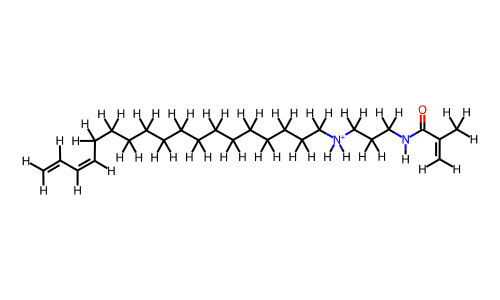

In [4]:
# create the molecule with RDkit from the SMILES. 
Molecule = openff.toolkit.topology.Molecule
mymol = Molecule.from_smiles('C=C/C=C\CCCCCCCCCCCCCC[NH2+]CCCNC(=O)C(=C)C')
mymol.visualize()

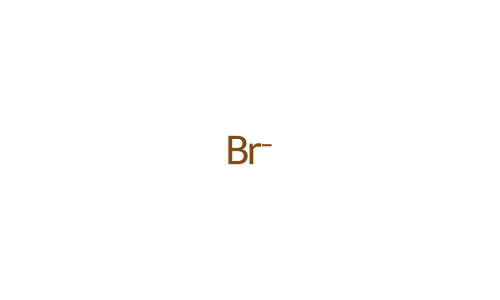

In [5]:
# create the counterion
mymol2 = Molecule.from_smiles('[Br-]')
mymol2.visualize()

In [6]:
# join the 2 in an OpenFF topology.
off_topology = Topology()
mols = [mymol,mymol2]
molecule_topology_indices = [off_topology.add_molecule(mols[index]) for index in range(2)]

In [ ]:
# convert it to RDkit form

In [7]:
mymol_rd = mymol.to_rdkit()

In [8]:
# load relevant RDkit commands
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

In [9]:
# create a configuration with RDkit.  Note - had to try a couple of 
# different seeds to get the stereochemistry on the carbonyl to match the picture. 
AllChem.EmbedMolecule(mymol_rd,randomSeed=0xf00f) 
print(Chem.MolToMolBlock(mymol_rd))


     RDKit          3D

 75 74  0  0  0  0  0  0  0  0999 V2000
    9.5243   -1.7477   -1.3001 C   0  0  0  0  0  0  0  0  0  0  0  0
    9.7417   -0.5144   -1.4332 C   0  0  0  0  0  0  0  0  0  0  0  0
    9.9831    0.8442   -1.5830 C   0  0  0  0  0  0  0  0  0  0  0  0
    9.5297    1.7567   -0.6585 C   0  0  0  0  0  0  0  0  0  0  0  0
    8.7974    1.1946    0.4621 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.3428    1.7004    0.5748 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.7624    0.9362    1.7227 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.3550    1.2282    2.0722 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.3779    1.0387    0.9713 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.4545   -0.3692    0.4215 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.4569   -0.5649   -0.7060 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0240   -0.4210   -0.2613 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1478   -0.5662   -1.4913 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3157   -0.5106   -1

In [10]:
# Now let's look at it to make sure it's right.  This doesn't have the counterion.
import nglview as nv

In [11]:
view = nv.show_rdkit(mymol_rd,fmt="SDK")

In [12]:
view

NGLWidget()

In [13]:
#Output the molecule to a pdb file
Chem.rdmolfiles.MolToPDBFile(mymol_rd,"monomer_before_minima.pdb")

In [14]:
# we need to add the counterion back in.

In [15]:
#First, load in the pdb.
f = open("monomer_before_minima.pdb","r")
lines = f.readlines()
f.close()
f = open("monomer_with_counterion.pdb","w")
firstconect = False
counterion = 'BR'
#counterion = 'CL'  # only works for monoatomic counterion
for l in lines:
    #figure out what line we are on currently
    if "HETATM" in l:
        atomn = int(l[6:12])
    if "HETATM" not in l and firstconect==False:
        cline = f"HETATM {atomn+1:4d}  {counterion:2s}1 UNL     1     -10.000  -5.000  -5.000  1.00  0.00           {counterion:2s}1-\n"
        f.write(cline)
        firstconect = True
    f.write(l)
f.close()    

In [16]:
forcefield = openff.toolkit.ForceField("openff-2.0.0.offxml")

In [17]:
from openff.interchange import Interchange

In [18]:
# this will take a little while since it has to run AM1-BCC for charges. I tihnk it's running ELF10?
interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=off_topology,
)


In [19]:
# load in coordiates from the new pdb
pdb = PDBFile('monomer_with_counterion.pdb')
interchange.positions = pdb.positions

In [20]:
# need to do some unit conversion with both packages
from openmm.unit import kelvin, picosecond, picoseconds, nanometer

openmm_sys = interchange.to_openmm(combine_nonbonded_forces=True)
openmm_top = interchange.topology.to_openmm()
openmm_pos = interchange.positions.m_as(unit.nanometer) * nanometer

In [21]:
from openmm import LangevinMiddleIntegrator
from openmm.app import Simulation, PDBReporter, StateDataReporter

# minimize in openmm, then run 1000 steps of MD simulation.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.0005*picoseconds)
simulation = Simulation(openmm_top, openmm_sys, integrator)
simulation.context.setPositions(openmm_pos)
simulation.minimizeEnergy()
simulation.reporters.append(PDBReporter('md_output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,350.53009033203125,138.06352770425778


In [ ]:
# look at the output structure to make sure it's reasonable.

In [22]:
view2=nv.show_file('md_output.pdb')

In [23]:
view2

NGLWidget()

In [24]:
# now convert the system to to AA GROMACS files for a single monomer + counterion. 
#The warning is fine, the box can be whatever size.
pdb = PDBFile('md_output.pdb')
interchange.positions = pdb.positions
interchange.to_gro("monomer.gro")
interchange.to_top("monomer.top")

/Users/mrshirts/opt/anaconda3/envs/openff/lib/python3.9/site-packages/openff/interchange/interop/internal/gromacs.py:164: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  warnings.warn(


In [ ]:
# note that it produces a full system file, this needs to be edited into a system top and a single molecule .itp. 

In [ ]:
# we need OpenFF glycerol as well. 

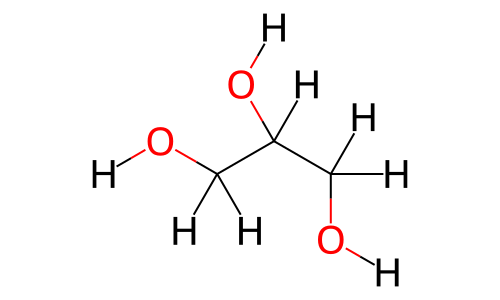

In [25]:
# create the molecule with RDkit from the SMILES. 
Molecule = openff.toolkit.topology.Molecule
solmol = Molecule.from_smiles('C(O)C(O)C(O)')
solmol.visualize()

In [26]:
solmol_rd = solmol.to_rdkit()

In [27]:
# create a configuration with RDkit.  Note - had to try a couple of 
# different seeds to get the stereochemistry on the carbonyl to match the picture. 
AllChem.EmbedMolecule(solmol_rd,randomSeed=0xf00f) 
print(Chem.MolToMolBlock(solmol_rd))


     RDKit          3D

 14 13  0  0  0  0  0  0  0  0999 V2000
   -1.3192   -0.1447   -0.1246 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4595   -1.5190   -0.1244 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.0571    0.3028    0.2941 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0906    1.6969    0.2596 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.1350   -0.2041   -0.6241 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.3540    0.3008   -0.1278 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0393    0.3455    0.5822 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5576    0.2258   -1.1434 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4720   -1.8782    0.7963 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.2371    0.0056    1.3475 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8142    2.0210    0.4539 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1861   -1.2935   -0.7001 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.0042    0.2553   -1.6245 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.5978   -0.1140    0

In [28]:
view = nv.show_rdkit(solmol_rd,fmt="SDK")

In [29]:
view

NGLWidget()

In [30]:
#Output the molecule to a pdb file
Chem.rdmolfiles.MolToPDBFile(solmol_rd,"solvent_before_minima.pdb")

In [31]:
# create OpenFF topology.
off_topology = Topology()
molecule_topology_indices = [off_topology.add_molecule(solmol) for index in range(1)]

In [33]:
# this will be fast since the molecule is small. 
interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=off_topology,
)


In [34]:
# load in coordiates from the new glycerol pdb
pdb = PDBFile('solvent_before_minima.pdb')
interchange.positions = pdb.positions

In [35]:
# need to do some unit conversion with both packages
openmm_sys = interchange.to_openmm(combine_nonbonded_forces=True)
openmm_top = interchange.topology.to_openmm()
openmm_pos = interchange.positions.m_as(unit.nanometer) * nanometer

In [36]:
# minimize in openmm, then run 1000 steps of MD simulation.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.0005*picoseconds)
simulation = Simulation(openmm_top, openmm_sys, integrator)
simulation.context.setPositions(openmm_pos)
simulation.minimizeEnergy()
simulation.reporters.append(PDBReporter('sol_output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,202.6815185546875,165.82355933201453


In [ ]:
# look at the output structure to make sure it's reasonable.

In [37]:
view2=nv.show_file('sol_output.pdb')

In [38]:
view2

NGLWidget()

In [39]:
pdb = PDBFile('sol_output.pdb')
interchange.positions = pdb.positions
interchange.to_gro("solvent.gro")
interchange.to_top("solvent.top")

In [ ]:
# again, will have to edit the .top to get an itp.